# Comparing number of event boundaries
### Started October 7, 2020

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.plotly as py
import plotly
import os
import glob
import math
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import copy
from random import randrange
import random
from sklearn.metrics import jaccard_score
from sklearn import datasets, linear_model
from scipy import stats
%autosave 5

Autosaving every 5 seconds


### i. Import data

In [2]:
filename = '/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/analysis/parsing_log_file/pickle/data_dict_pilots_b1_b2_b3_b4_b5.p'
data_dict = pickle.load( open( filename, "rb" ) )

### ii. import and organize story files
#### a. Import file

In [5]:
directory_stories = '/Users/alexreblando/Documents/GitHub/ebs/fMRI experiment/1:8:2020_edited_stories'

filenames_stories = glob.glob(directory_stories + '/*.xlsx')

dfs_stories = []
    
for filename in filenames_stories:
    dfs_stories.append(pd.read_excel(filename))

#### b. organize putative event boundaries

In [6]:
#mark the boundaries with a '1'
#output: story_boundaries, where the first column has the location boundaries and the second column has the social
#boundaries

story_boundaries = dict()

#read in the location and social event values from the story files 
for s in range(16):
    this_story = int(dfs_stories[s]['story'].iloc[0])
    keys2 = dfs_stories[s]['locationEvent'].values
    keys3 = dfs_stories[s]['socialEvent'].values
    story_boundaries[this_story] = keys2[:, np.newaxis]
    story_boundaries[this_story] = np.concatenate((story_boundaries[this_story], keys3[:, np.newaxis]), axis = 1)
    
#mark the changes or boundaries from one event to another with a '1' and delete first two columns
for key in story_boundaries:
    location = story_boundaries[key][:,0]
    social = story_boundaries[key][:,1]
    for i in range(0, len(location)):  
        if location[i] > location[i-1]:
            location[i] = 7
    for i in range(0, len(location)):  
        if location[i] != 7:
            location[i] = 0
    for i in range(0, len(social)):
        if social[i] > social[i - 1]:
            social[i] = 7
    for i in range(0, len(social)):
        if social[i] != 7:
            social[i] = 0
    location[0] = 7
    social[0] = 7
    location2 = location > 1
    social2 = social > 1
    location2 = location2.astype(int)
    social2 = social2.astype(int)
    story_boundaries[key] = np.concatenate((story_boundaries[key], location2[:, np.newaxis]), axis = 1) 
    story_boundaries[key] = np.concatenate((story_boundaries[key], social2[:, np.newaxis]), axis = 1)
    story_boundaries[key] = np.delete(story_boundaries[key] ,np.s_[0:2],axis=1)

### iii. Exclusions
#### a. exclude participants who only pressed '1' or '9'

In [7]:
keys_to_del = []
for key in data_dict:
    kp = data_dict[key]['story_presses']
    kp_i = kp.iloc[1:]
    check_kp_i = len(set(kp_i))
    if check_kp_i == 1:
        print(key)
        print(data_dict[key]['prolific_id'].iloc[0])
        keys_to_del.append(key)
        
for i in range(0, len(keys_to_del)):
    del data_dict[keys_to_del[i]]

#### b. Exclude participants who don't answer short answers

In [8]:
del data_dict['/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b1/33/73_1_online_exp_2020-06-10_14h37.05.252']
del data_dict['/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b2/30/199_1_online_exp_2020-06-24_20h41.05.680']
del data_dict['/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b3/45/345_1_online_exp_2020-07-16_09h07.09.087']

#### c. Exclude participants who said said more than half the sentences were a boundary

In [9]:
keys_to_del = []

for key in data_dict:
    kp = data_dict[key]['story_presses']
    N_kp= np.sum(kp == 9)
    this_story = data_dict[key]['story'].iloc[0]
    half_story_len = np.rint(len(story_boundaries[this_story])/2)
    if N_kp >= half_story_len:
        print(key)
        print(data_dict[key]['prolific_id'].iloc[0])
        keys_to_del.append(key)
        
for i in range(0, len(keys_to_del)):
    del data_dict[keys_to_del[i]]

/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/pilot2/8/PARTICIPANT_1_online_exp_2020-05-11_20h42.51.597
5ce5b9844cd8130019acba32
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/pilot4/7/PARTICIPANT_1_online_exp_2020-05-27_21h05.22.618
5d46c556fb0ce0001a04fd01
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_p/10/18_1_online_exp_2020-06-06_14h58.27.858
571ceeb64ca277000953d1c1
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_p/10/21_1_online_exp_2020-06-06_15h20.03.392
5eda9f7c460b766ded73bdb7
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_p/10/24_1_online_exp_2020-06-09_20h39.35.048
5ea616a090d52b61615dfb3b
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b1/33/152_1_online_exp_2020-06-10_21h15.29.074
5d331b4c9ce6590019010930
/Users/alexreblando/Documents/GitHub/data_analys

#### d. Pickle data_dict in order to get group counts

In [10]:
pickle.dump( data_dict, open( 'check', "wb" ) )

# I. Separating the Priming Groups For Each Story
## A. group stories by subject and priming type
#### - output: loc_keys_r

In [11]:
loc_keys_r = dict()
soc_keys_r = dict()
none_keys_r = dict()
all_keys_r = dict()

for key in data_dict:
    this_story = data_dict[key]['story'].iloc[0]
    keys = data_dict[key]['story_presses']
    p_type = data_dict[key]['p_type'].iloc[0]
    #print out the filenames and prolific ids of people who did not press "9" once
    occurrences = np.count_nonzero(keys == 9)
    if occurrences == 0:
        print(key)
        print(data_dict[key]['prolific_id'].iloc[0])
    #put all story keys in the same dictionary regardless of priming
    if this_story in all_keys_r:
        all_keys_r[this_story] = np.concatenate((all_keys_r[this_story],keys[:,np.newaxis]), axis=1)
    else:
        all_keys_r[this_story] = keys[:, np.newaxis]
    #organize keys by priming type
    #no prime
    if p_type == 0:
        if this_story in none_keys_r:
            none_keys_r[this_story] = np.concatenate((none_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            none_keys_r[this_story] = keys[:, np.newaxis]
    #loc prime
    elif p_type == 1:
        if this_story in loc_keys_r:
            loc_keys_r[this_story] = np.concatenate((loc_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            loc_keys_r[this_story] = keys[:, np.newaxis]
    #soc prime
    elif p_type == 2:
        if this_story in soc_keys_r:
            soc_keys_r[this_story] = np.concatenate((soc_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            soc_keys_r[this_story] = keys[:, np.newaxis]

### i. Finding the number of participants in each category for each story
#### -output sums[story] = [total # of participants, no prime, loc primed, soc primed]

In [12]:
sums = {}

for key in all_keys_r:
    this_sum = []
    x, y = all_keys_r[key].shape
    this_sum.append(y)
    if key in none_keys_r:
        x, y = none_keys_r[key].shape
        this_sum.append(y)
    else:
        this_sum.append(0)
    if key in loc_keys_r:
        x, y = loc_keys_r[key].shape
        this_sum.append(y)
    else:
        this_sum.append(0)
    if key in soc_keys_r:
        x, y = soc_keys_r[key].shape
        this_sum.append(y)
    else:
        this_sum.append(0)
    sums[key] = this_sum

## B. Convert keypresses from '9's and '1's to '1's and '0's
#### - output loc_keys
#### - WARNING: you can only run this once!!!!!! if you run twice, you must start from the beginning

In [13]:
loc_keys = dict()
soc_keys = dict()
none_keys = dict()
all_keys = dict()

#all keys
for key in all_keys_r:
    this_array = copy.deepcopy(all_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    all_keys[key] = this_array   
    
#none keys
for key in none_keys_r:
    this_array = copy.deepcopy(none_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    none_keys[key] = this_array   
    
#loc keys
for key in loc_keys_r:
    this_array = copy.deepcopy(loc_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    loc_keys[key] = this_array   
    
#soc keys
for key in soc_keys_r:
    this_array = copy.deepcopy(soc_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    soc_keys[key] = this_array   

## C. Remove first sentence (first row) from all keypresses

In [14]:
list_keys = [all_keys, none_keys, loc_keys, soc_keys]
for i in range(0, len(list_keys)):
    for key in list_keys[i]:
        list_keys[i][key] = np.delete(list_keys[i][key],(0), axis = 0)

# III. Counting the number of event boundaries
## A. Median and mean number of boundaries across all participants

In [15]:
# Append all subj's boundary count
bndrs_count = []
for key in all_keys:
    if key in none_keys:
        for i in range(0, none_keys[key].shape[1]):
            this_col = none_keys[key][:,i]
            bndrs_count.append(np.count_nonzero(this_col == 1))
    if key in loc_keys:
        for i in range(0, loc_keys[key].shape[1]):
            this_col = loc_keys[key][:,i]
            bndrs_count.append(np.count_nonzero(this_col == 1))
    if key in soc_keys:
        for i in range(0, soc_keys[key].shape[1]):
            this_col = soc_keys[key][:,i]
            bndrs_count.append(np.count_nonzero(this_col == 1))

# Convert bndrs_count list to array
print(bndrs_count)
np_bc = np.asarray(bndrs_count)
print(np_bc)
bc_median = np.median(np_bc)
bc_mean = np.mean(np_bc)
print('The median number of boundaries across all subjects is ', bc_median)
print('The mean number of boundaries across all subjects is ', bc_mean)

[6, 6, 6, 9, 4, 12, 5, 10, 17, 5, 11, 11, 6, 16, 9, 8, 4, 3, 14, 13, 1, 8, 12, 3, 13, 8, 10, 5, 5, 7, 5, 10, 13, 14, 10, 5, 8, 6, 8, 5, 5, 9, 4, 3, 7, 3, 7, 8, 8, 3, 15, 17, 5, 8, 6, 15, 5, 4, 7, 2, 7, 5, 6, 11, 2, 2, 6, 3, 13, 4, 10, 10, 7, 5, 10, 10, 9, 4, 10, 4, 3, 12, 5, 4, 5, 6, 1, 8, 4, 7, 9, 4, 10, 10, 8, 6, 10, 7, 3, 2, 11, 7, 4, 4, 9, 7, 7, 10, 7, 8, 2, 3, 4, 11, 9, 7, 3, 1, 5, 12, 8, 6, 13, 6, 9, 7, 3, 8, 7, 9, 7, 7, 7, 2, 6, 7, 9, 8, 6, 5, 6, 6, 4, 2, 3, 8, 10, 2, 12, 5, 4, 8, 6, 4, 5, 13, 9, 13, 7, 8, 13, 12, 6, 6, 13, 8, 8, 8, 7, 6, 8, 7, 7, 6, 9, 7, 10, 13, 9, 7, 6, 10, 8, 11, 15, 13, 5, 9, 3, 9, 9, 9, 8, 4, 7, 9, 4, 7, 9, 7, 7, 7, 7, 2, 7]
[ 6  6  6  9  4 12  5 10 17  5 11 11  6 16  9  8  4  3 14 13  1  8 12  3
 13  8 10  5  5  7  5 10 13 14 10  5  8  6  8  5  5  9  4  3  7  3  7  8
  8  3 15 17  5  8  6 15  5  4  7  2  7  5  6 11  2  2  6  3 13  4 10 10
  7  5 10 10  9  4 10  4  3 12  5  4  5  6  1  8  4  7  9  4 10 10  8  6
 10  7  3  2 11  7  4  4  9  7  7 10  7  8  2

## B. Comparing the median and mean number of boundaries for different priming types across all stories

In [16]:
# Append all subj's boundary count
bc_none = []
bc_loc = []
bc_soc = []
for key in all_keys:
    if key in none_keys:
        for i in range(0, none_keys[key].shape[1]):
            this_col = none_keys[key][:,i]
            bc_none.append(np.count_nonzero(this_col == 1))
    if key in loc_keys:
        for i in range(0, loc_keys[key].shape[1]):
            this_col = loc_keys[key][:,i]
            bc_loc.append(np.count_nonzero(this_col == 1))
    if key in soc_keys:
        for i in range(0, soc_keys[key].shape[1]):
            this_col = soc_keys[key][:,i]
            bc_soc.append(np.count_nonzero(this_col == 1))

# Convert bndrs_count list to array
np_bc_none = np.asarray(bc_none)
np_bc_loc = np.asarray(bc_loc)
np_bc_soc = np.asarray(bc_soc)
# Finding median and mean
bc_none_median = np.median(np_bc_none)
bc_none_mean = np.mean(np_bc_none)
bc_loc_median = np.median(np_bc_loc)
bc_loc_mean = np.mean(np_bc_loc)
bc_soc_median = np.median(np_bc_soc)
bc_soc_mean = np.mean(np_bc_soc)
# Printing
print('The median and mean numbers of boundaries for no-prime respectively are ', bc_none_median, ' and ', bc_none_mean)
print('The median and mean numbers of boundaries for loc-prime respectively are ', bc_loc_median, ' and ', bc_loc_mean)
print('The median and mean numbers of boundaries for soc-prime respectively are ', bc_soc_median, ' and ', bc_soc_mean)

The median and mean numbers of boundaries for no-prime respectively are  6.0  and  6.935483870967742
The median and mean numbers of boundaries for loc-prime respectively are  7.0  and  7.864197530864198
The median and mean numbers of boundaries for soc-prime respectively are  7.0  and  7.016129032258065


## C. Median and mean number of boundaries across all participants for each story
### i. Calculating each story's median and mean

In [17]:
# Append all subj's boundary count
list_keys = [11, 12, 13, 14, 21, 22, 23, 24, 31, 32, 33, 34, 41, 42, 43, 44]

story_medians = []
story_means = []

for key in list_keys:
    bndrs_count = []
    if key in none_keys:
        for i in range(0, none_keys[key].shape[1]):
            this_col = none_keys[key][:,i]
            bndrs_count.append(np.count_nonzero(this_col == 1))
    if key in loc_keys:
        for i in range(0, loc_keys[key].shape[1]):
            this_col = loc_keys[key][:,i]
            bndrs_count.append(np.count_nonzero(this_col == 1))
    if key in soc_keys:
        for i in range(0, soc_keys[key].shape[1]):
            this_col = soc_keys[key][:,i]
            bndrs_count.append(np.count_nonzero(this_col == 1))

    # Convert bndrs_count list to array
    this_np_bc = np.asarray(bndrs_count)
    this_bc_median = np.median(this_np_bc)
    this_bc_mean = np.mean(this_np_bc)
    
    # Concatenate median and mean
    story_medians.append(this_bc_median)
    story_means.append(this_bc_mean)
    
    

### ii. Plotting the median and means by order of the story

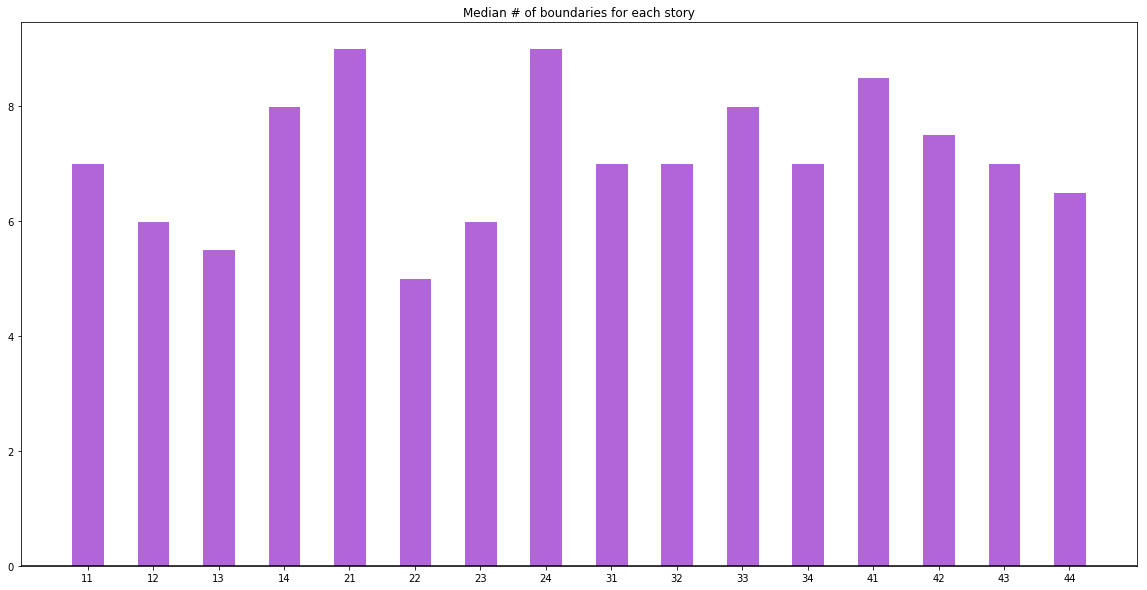

<Figure size 432x288 with 0 Axes>

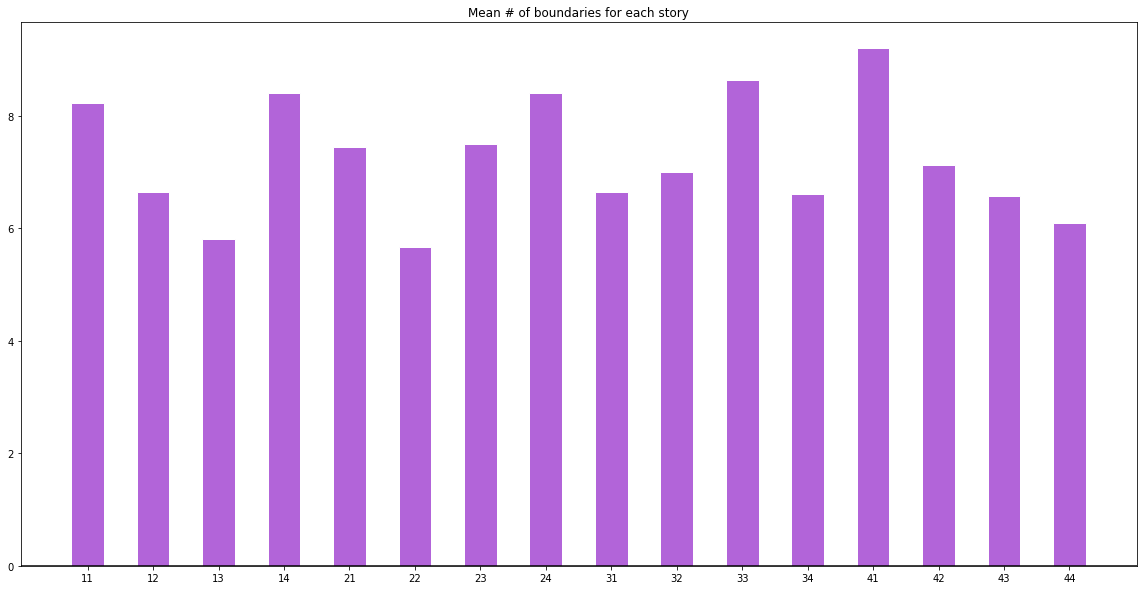

In [18]:
story_list = ['11', '12', '13', '14', '21', '22', '23', '24', '31', '32', '33', '34', '41', '42', '43', '44']

# Plotting
# Set position of bars on X axis
r1 = np.arange(16)

plt.figure(figsize=(20,10))

plot_medians = np.asarray(story_medians)
barWidth = 0.5
plt.bar(story_list, plot_medians, color= '#b264d9' , width=barWidth, edgecolor='white')
plt.title('Median # of boundaries for each story')
#drawing x axis
plt.axhline(y=0, color = '#000000')

plt.figure()

# Plotting means

plt.figure(figsize=(20,10))

plot_means = np.asarray(story_means)
barWidth = 0.5
plt.bar(story_list, plot_means, color= '#b264d9' , width=barWidth, edgecolor='white')
plt.title('Mean # of boundaries for each story')
#drawing x axis
plt.axhline(y=0, color = '#000000')

### iii. Plotting median and mean as a function of the number of sentences in a story

Text(0.5, 1.0, 'Means')

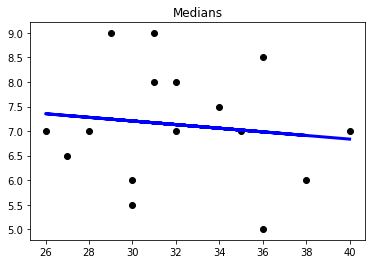

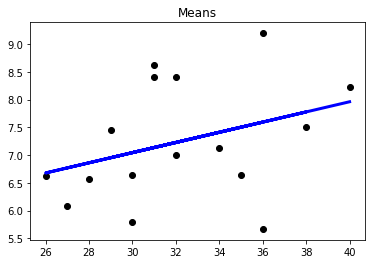

In [19]:
story_lens = np.zeros((16, 1))

for i in range(0,16):
    story_lens[i] = all_keys[list_keys[i]].shape[0]
    
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(story_lens, plot_medians)

# Make predictions using the testing set
pred_y = regr.predict(story_lens)

# Plot outputs
plt.scatter(story_lens, plot_medians,  color='black')
plt.plot(story_lens, pred_y, color='blue', linewidth=3)

# Title
plt.title('Medians')

plt.figure()

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(story_lens, plot_means)

# Make predictions using the testing set
pred_y = regr.predict(story_lens)

# Plot outputs
plt.scatter(story_lens, plot_means,  color='black')
plt.plot(story_lens, pred_y, color='blue', linewidth=3)

# Title
plt.title('Means')



# IV. Statistical Analysis: Two-Sample Unpaired T-test
## A. Comparison between the means of number of location and social boundaries
### - boundary counts include participants from all stories

In [20]:
t, p = stats.ttest_ind(np_bc_loc, np_bc_soc, equal_var = False)
print('The p value is ', p)

The p value is  0.10656844021503274


## B. Comparison between the means of the number of location and no-prime boundaries

In [21]:
t, p = stats.ttest_ind(np_bc_loc, np_bc_none, equal_var = False)
print('The p value is ', p)

The p value is  0.1181206047962142


## C. Comparison between the means of the number of location and no-prime boundaries

In [22]:
t, p = stats.ttest_ind(np_bc_soc, np_bc_none, equal_var = False)
print('The p value is ', p)

The p value is  0.8901895219954381


# V. The Range of Boundary Numbers
## A. Find the smallest and the largest number of keypresses across all participants in all stories

In [23]:
this_min = np.amin(np_bc)
this_max = np.amax(np_bc)
print("The range is from ", this_min, " to ", this_max)

The range is from  1  to  17


## B. Histogram of boundaries with median and mean plotted

3.301959831213615


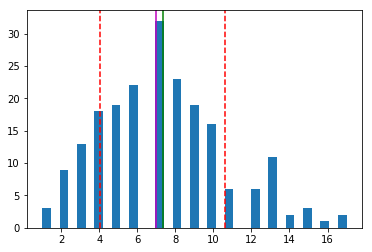

In [24]:
plt.hist(np_bc, bins = 35)
plt.axvline(x=bc_median, color='m')
plt.axvline(x=bc_mean, color='g')
#calculate standard deviation
sd = np.std(np_bc)
#plot sd
plt.axvline(x= (bc_mean + sd), color='r', linestyle='--')
plt.axvline(x= (bc_mean - sd), color='r', linestyle='--')
print(sd)

plt.show()

In [25]:
## maybe exclude participants who are a standard of deviation away from the mean?

In [26]:
print('The total number of participants is ', len(np_bc))
final_list = [x for x in np_bc if (x > bc_mean - sd)]
print(bc_mean - sd)
final_list = [x for x in final_list if (x < bc_mean +sd)]
print(bc_mean + sd)
print('The number of participants within the first standard deviation is ', len(final_list))

The total number of participants is  205
4.024869437079069
10.628789099506298
The number of participants within the first standard deviation is  131
